In [1]:
import pandas as pd
import numpy as np
import warnings
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

OAK = 'FOAK'

cogen = True
cambium_scenario = 'MidCase'
year = 2024
if cogen: cogen_tag = 'cogen'
else: cogen_tag = 'nocogen'
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Import ANR-H2 input parameters

In [2]:
h2_techs = pd.read_excel('./h2_tech.xlsx', sheet_name = 'Summary')
h2_techs.rename(columns={'CAPEX ($/MWe)':'H2 CAPEX ($/MWe)',
                 'FOM ($/MWe-year)':'H2 FOM ($/MWe-year)',
                 'VOM ($/MWhe)':'H2 VOM ($/MWhe)'}, inplace=True)
anrs = pd.read_excel('./ANRs.xlsx', sheet_name=OAK)
anrs.rename(columns={'CAPEX $/MWe':'ANR CAPEX ($/MWe)',
                 'FOPEX $/MWe-y':'ANR FOM ($/MWe-year)',
                 'VOM in $/MWh-e':'ANR VOM ($/MWhe)', 
                 'Startupfixedcost in $':'Start Cost ($)'}, inplace=True)
techs = pd.merge(h2_techs, anrs, left_on='ANR', right_on='Reactor')

# Natural Gas

In [3]:
# Avoided NG costs
def compute_ng_multiplier(temp, AHF_coeffs=[0, -.00038, 0.90556]):
  # Available Heat Fraction
  AHF = AHF_coeffs[0]*(int(temp)**2)+ AHF_coeffs[1]*int(temp) + AHF_coeffs[2]
  multiplier = AHF/utils.mmbtu_to_mj # Unit: MmBtu/MJ
  return multiplier

# Merge state-level prices
ng_prices = pd.read_excel('./input_data/eia_aeo_industrial_sector_ng_prices.xlsx', sheet_name='state_prices')
# 2024 prices
ng_prices = ng_prices[ng_prices.year == 2024]
ng_prices.rename(columns={'price 2020USD/MMBtu':'NG price ($/MMBtu)'}, inplace=True)

# Coordinates

In [4]:
locations_file = './results/process_heat/heat_facilities_locations.csv'
if not os.path.isfile(locations_file):
  loc_data = pd.read_excel('./input_data/direct_heat_maxv/facs_batched.xlsx')[['CITY', 'STATE']].drop_duplicates(ignore_index=True)
  geolocator = Nominatim(user_agent="your_app_name")
  geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

  # Function to apply geocoding
  def geocode_location(row):
      # Try to geocode using city and state, else return NaN
      try:
          location = geocode(f"{row['CITY']}, {row['STATE']}, USA")
          return location.latitude, location.longitude
      except:
          return pd.NA, pd.NA

  # Apply the geocoding function to each row
  loc_data['latitude'], loc_data['longitude'] = zip(*loc_data.apply(geocode_location, axis=1))
  loc_data.to_csv(locations_file, index=False)
else:
  loc_data = pd.read_csv(locations_file)

In [5]:
loc_data

,CITY,STATE,latitude,longitude
0,East Chicago,IN,41.639786,-87.454847
1,CLEVELAND,OH,41.499657,-81.693677
2,BURNS HARBOR,IN,41.625871,-87.133368
3,MIDDLETOWN,OH,39.516644,-84.404173
4,DEARBORN,MI,42.322260,-83.176315
...,...,...,...,...
745,WEST BURLINGTON,IA,40.825083,-91.156550
746,GIBSON CITY,IL,40.465312,-88.375888
747,JACKSON,NE,42.448296,-96.565531
748,ST ANSGAR (MONA),IA,NaN,NaN


# ANR +  ANR-H2 Analysis

## Load batched NREL data from MAX

In [6]:
nrel_data = pd.read_excel('./input_data/direct_heat_maxv/facs_batched.xlsx')
nrel_data.drop(columns=['Unnamed: 0', 'Total'], inplace=True)
nrel_data.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper'],
      dtype='object')

In [7]:
# Load results from MAX
max_results = pd.read_csv('./input_data/direct_heat_maxv/Full_Spread_SMRs.csv')
max_results.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
assert len(max_results) <= len(nrel_data)*5
max_results.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'Total', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper', 'Reactor', 'Power in MWt', 'Thermal Efficiency',
       'Outlet Temp (C)', 'CAPEX $/MWe_foak', 'FOPEX $/MWe-y_foak',
       'VOM in $/MWh-e_foak', 'CAPEX $/MWe', 'FOPEX $/MWe-y', 'VOM in $/MWh-e',
       'Life (y)', 'Modules', 'SMR_Capacity', 'SMR_Capacity_e',
       'Surplus_Capacity', 'Surplus_Capacity_e', 'CRF', 'Total_CAPEX_FOAK',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 

## Compute H2 demand for unserved demand

In [8]:
def compute_h2_demand(heat, temp, AHF_coeffs = [0, -0.00038, .90556]):
  """Computes the equivalent hydrogen demand to produce heat 
  Args:
    - heat (float): heat demand in MW
    - temp (float): temperature in degree Celsius
    - AHF_coeffs (list(float)): coefficients for Available Heat Fraction calculation
  Returns:
    - h2_demand (float): hydrogen demand in kg/h
  """
  AHF = AHF_coeffs[0]*(int(temp)^2) + AHF_coeffs[1]*int(temp) + AHF_coeffs[2]
  h2_demand = heat*utils.mwh_to_mj/(utils.h2_hhv*AHF)
  return h2_demand
max_results['Remaining H2 Dem. (kg/h)'] = max_results.apply(lambda x:compute_h2_demand(x['Remaining_Heat_MW'], x['Remaining_temp_degC']), axis=1)

## Compute ANR Net Annual Revenues from Max results for FOAK/NOAK

In [9]:
max_results[f'ANR Net Ann. Rev. {OAK} ($/year)'] = -(max_results[f'Annual_CAPEX_{OAK}']+max_results[f'FOPEX_{OAK}']+max_results[f'VOPEX_{OAK}'])+\
                                                    max_results['Revenues']

In [10]:
ng_df = max_results[['FACILITY_ID','STATE','CITY','Batch_Temp_degC', 'Highest_Temp_served_degC', 'Emissions_mmtco2/y',\
                    'Heat_demand_MWh/hr', 'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod', 'Reactor',\
                    'Modules', 'SMR_Capacity', 'SMR_Capacity_e','Surplus_Capacity', 'Surplus_Capacity_e', \
                    f'Annual_CAPEX_{OAK}', f'FOPEX_{OAK}', f'VOPEX_{OAK}', f'Annual_Cost_{OAK}',\
                    'NG price ($/MMBtu)', 'Revenues', f'ANR Net Ann. Rev. {OAK} ($/year)', 'Remaining H2 Dem. (kg/h)']]
ng_df.to_csv(f'./results/process_heat/max_results_full_{OAK}.csv')

## Map emissions to batch or max temp

In [11]:
# Compute the ratio of NG burned for batch temperature and remaining temperature demand
ng_df['NG_batch'] = ng_df.apply(lambda x:compute_ng_multiplier(x['Batch_Temp_degC'])*x['Heat_demand_MWh/hr'], axis=1)
ng_df['NG_rem'] = ng_df.apply(lambda x:compute_ng_multiplier(x['Remaining_temp_degC'])*x['Remaining_Heat_MW'], axis=1)
ng_df['NG_batch_ratio'] = ng_df['NG_batch']/(ng_df['NG_batch']+ng_df['NG_rem'])
ng_df['NG_rem_ratio'] = ng_df['NG_rem']/(ng_df['NG_batch']+ng_df['NG_rem'])
ng_df['Emissions_batch_mmtco2/y'] = ng_df['NG_batch_ratio']*ng_df['Emissions_mmtco2/y']
ng_df['Emissions_rem_mmtco2/y'] = ng_df['NG_rem_ratio']*ng_df['Emissions_mmtco2/y']

## Compute ANR deployment and cashflows

In [12]:
fr = ng_df.merge(techs, left_on='Reactor', right_on='ANR') # facilities remaining demand
fr.columns


Index(['FACILITY_ID', 'STATE', 'CITY', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Reactor_x', 'Modules', 'SMR_Capacity', 'SMR_Capacity_e',
       'Surplus_Capacity', 'Surplus_Capacity_e', 'Annual_CAPEX_FOAK',
       'FOPEX_FOAK', 'VOPEX_FOAK', 'Annual_Cost_FOAK', 'NG price ($/MMBtu)',
       'Revenues', 'ANR Net Ann. Rev. FOAK ($/year)',
       'Remaining H2 Dem. (kg/h)', 'NG_batch', 'NG_rem', 'NG_batch_ratio',
       'NG_rem_ratio', 'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Technology', 'ANR', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor_y', 'Type', 'Power 

In [13]:
import math
fr['H2 Modules'] = fr.apply(lambda x: math.ceil(x['Remaining H2 Dem. (kg/h)']/x['H2Cap (kgh2/h)']), axis=1)
fr['Depl. H2 Cap. (kgh2/h)'] = fr['H2 Modules']*fr['H2Cap (kgh2/h)']
fr['Depl. H2 Cap. (MWe)'] = fr['H2 Modules']*fr['H2Cap (MWe)']
fr['ANR Modules'] = fr.apply(lambda x: math.ceil(x['Depl. H2 Cap. (MWe)']/x['Power in MWe']), axis=1)
fr['Depl. ANR Cap. (MWe)'] = fr['ANR Modules']*fr['Power in MWe']
fr['Depl. ANR Cap. (MWt)'] = fr['ANR Modules']*fr['Power in MWt']
fr['Surplus ANR Cap. (MWe)'] = fr['Depl. ANR Cap. (MWe)']-fr['Depl. H2 Cap. (MWe)']
fr['Surplus ANR Cap. (MWt)'] = fr['Surplus ANR Cap. (MWe)']/fr['Thermal Efficiency']

In [14]:
# Compute costs in $/year
# Capital recovery factor
IR = utils.WACC
fr['ANR CRF'] = (IR/(1-((1+IR)**(-1*(fr['Life (y)_y'])))))
fr['H2 CRF'] = (IR/(1-((1+IR)**(-1*(fr['Life (y)_x'])))))
itc_anr = utils.ITC_ANR
itc_h2 = utils.ITC_H2

## CAPEX
fr['Tot ANR CAPEX'] = fr['Depl. ANR Cap. (MWe)']*fr['ANR CAPEX ($/MWe)']
fr['Annual ANR CAPEX'] = fr['Tot ANR CAPEX']*fr['ANR CRF']*(1-itc_anr)
fr['Tot H2 CAPEX'] = fr['Depl. H2 Cap. (MWe)']*fr['H2 CAPEX ($/MWe)']
fr['Annual H2 CAPEX'] = fr['Tot H2 CAPEX']*fr['H2 CRF']*(1-itc_h2)
fr['Annual ANR-H2 CAPEX'] = fr['Annual ANR CAPEX']+fr['Annual H2 CAPEX']

## FOM
fr['ANR FOM'] = fr['Depl. ANR Cap. (MWe)']*fr['ANR FOM ($/MWe-year)']
fr['H2 FOM'] = fr['Depl. H2 Cap. (MWe)']*fr['H2 FOM ($/MWe-year)']
fr['ANR-H2 FOM'] = fr['ANR FOM']+fr['H2 FOM']

## VOM
fr['ANR VOM'] =fr['Remaining H2 Dem. (kg/h)']*8760*fr['Eq tot H2ElecCons (MWhe/kgh2)']*fr['ANR VOM ($/MWhe)']
fr['H2 VOM'] =fr['Remaining H2 Dem. (kg/h)']*8760*fr['H2 VOM ($/MWhe)']
fr['ANR-H2 VOM'] = fr['ANR VOM']+fr['H2 VOM']

## Conversion costs
gf_crf = IR/ (1 - (1/(1+IR)**utils.GFLT) ) 
fr['Conversion'] = utils.GFCAPEX*gf_crf*(1-itc_h2)*fr['Remaining_Heat_MW']

# Total cost
fr['ANR-H2 Total Cost ($/year)'] = fr['Annual ANR-H2 CAPEX'] + fr['ANR-H2 FOM'] + fr['ANR-H2 VOM'] + fr['Conversion']


In [15]:
# Compute revenues in $/year
# Avoided NG costs
fr['NG Mult (MMBtu/MJ)'] = fr.apply(lambda x: compute_ng_multiplier(x['Remaining_temp_degC']), axis=1) 

fr['Avoided NG Cost'] = fr['NG price ($/MMBtu)']*fr['NG Mult (MMBtu/MJ)']*fr['Remaining_Heat_MW']*utils.mwh_to_mj*8760

# H2 PTC
fr['H2 PTC'] = utils.h2_ptc*fr['Remaining H2 Dem. (kg/h)']*8760

# Compute total deployed ANR capacity 
fr['Depl. ANR Cap. (MWe)'] = fr['Depl. ANR Cap. (MWe)']+fr[ 'SMR_Capacity_e']
fr['Depl. ANR Cap. (MWt)'] = fr['Depl. ANR Cap. (MWt)']+fr[ 'SMR_Capacity']
fr['Surplus ANR Cap. (MWe)'] = fr['Surplus ANR Cap. (MWe)']+fr['Surplus_Capacity_e']
fr['Surplus ANR Cap. (MWt)'] = fr['Surplus ANR Cap. (MWt)']+fr['Surplus_Capacity']
fr['ANR Modules'] = fr['ANR Modules']+fr['Modules']


In [16]:
def compute_average_electricity_prices(cambium_scenario, year):
  folder = f'./input_data/cambium_{cambium_scenario.lower()}_state_hourly_electricity_prices'
  list_csv_files = glob.glob(folder+'/Cambium*.csv')
  state_prices = pd.DataFrame(columns=['average price ($/MWhe)', 'state'])
  state_prices.set_index('state', inplace=True)
  for file in list_csv_files:
    if str(year) in file:
      state = file.split('_')[-2]
      avg_price = pd.read_csv(file, skiprows=5)['energy_cost_enduse'].mean()
      state_prices.loc[state, 'average price ($/MWhe)'] = avg_price
  state_prices.to_excel(f'./results/average_electricity_prices_{cambium_scenario}_{year}.xlsx')


def compute_cogen(df, surplus_cap_col_name, state_col_name):
  try:
    elec_prices_df = pd.read_excel(f'./results/average_electricity_prices_{cambium_scenario}_{year}.xlsx', index_col=0)
  except FileNotFoundError:
    compute_average_electricity_prices(cambium_scenario, year)
    elec_prices_df = pd.read_excel(f'./results/average_electricity_prices_{cambium_scenario}_{year}.xlsx', index_col=0)
  df['Electricity revenues ($/y)'] = df.apply(lambda x: x[surplus_cap_col_name]*elec_prices_df.loc[x[state_col_name]]*8760, axis=1)
  return df
  

In [17]:
# Revenues = - (Cost of ANR+Cost of ANR-H2)+ Avoided cost of NG +H2 PTC Revenues
fr['Net Ann. Rev. ($/year)'] = -fr['ANR-H2 Total Cost ($/year)']+fr['H2 PTC']+fr['Avoided NG Cost']\
                                      +fr[f'ANR Net Ann. Rev. {OAK} ($/year)']
if cogen: 
  fr = compute_cogen(fr, 'Surplus ANR Cap. (MWe)', 'STATE')
  fr['Net Ann. Rev. ($/year)'] += fr['Electricity revenues ($/y)']

fr.to_csv(f'./results/process_heat/anr+anrh2_full_{OAK}_{cogen_tag}.csv')


In [18]:
# Select best hydrogen technology
# Select h2 tech corresponding to the maximum net annual revenue
fr.reset_index(inplace=True, drop=True)
idx = fr.groupby(['FACILITY_ID', 'Remaining_temp_degC', 'ANR'])['Net Ann. Rev. ($/year)'].idxmax()
max_h2 = fr.loc[idx]
print(len(fr), len(max_h2))
fr = max_h2  

23502 7834


In [19]:
# Total avoided NG cost
fr['Avoided NG Cost ($/y)'] = fr['Avoided NG Cost']+fr['Revenues']

fr.drop(columns=['SMR_Capacity_e', 'SMR_Capacity', 'Surplus_Capacity', 'Surplus_Capacity_e','H2 CRF',  'H2Cap (MWe)',
       'H2Cap (kgh2/h)', 'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Reactor_y','Reactor_x', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)','ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Life (y)_y', 'NG Mult (MMBtu/MJ)', 'Avoided NG Cost', 'Revenues',
       'Modules',  'NG_batch','NG_rem', 'NG_batch_ratio', 'NG_rem_ratio',], inplace=True)


In [20]:
fr.to_csv(f'./results/process_heat/anr+anrh2_after_h2_opt_{OAK}_{cogen_tag}.csv')

## Select best ANR design for each facility

In [21]:
# Select ANR design corresponding to the maximum net annual revenue
fr.reset_index(inplace=True, drop=True)
idx = fr.groupby(['FACILITY_ID'])['Net Ann. Rev. ($/year)'].idxmax()
max_anr = fr.loc[idx]
print(len(fr), len(max_anr))
fr = max_anr.reset_index(drop=True)     
fr

7834 913


,FACILITY_ID,STATE,CITY,Batch_Temp_degC,Highest_Temp_served_degC,Emissions_mmtco2/y,Heat_demand_MWh/hr,Remaining_Heat_MW,Remaining_temp_degC,Temp_Req,...,ANR-H2 FOM,ANR VOM,H2 VOM,ANR-H2 VOM,Conversion,ANR-H2 Total Cost ($/year),H2 PTC,Net Ann. Rev. ($/year),Electricity revenues ($/y),Avoided NG Cost ($/y)
0,1000022,TX,TEXAS CITY,421.391304,900,0.028326,19.626266,0.000000,0.0,949,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.476944e+06,1.179847e+04,3.269682e+06
1,1000025,LA,PORT ALLEN,457.187911,600,0.050151,34.747554,0.000000,0.0,629,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.913940e+06,3.427753e+07,5.897046e+06
2,1000029,WA,SEATTLE,180.000000,180,0.005027,3.483160,23.098853,1100.0,301,...,15946320.0,6.539422e+06,0.0,6.539422e+06,2.830536e+06,6.019711e+07,3.159141e+07,-1.382665e+07,5.575849e+07,2.628773e+06
3,1000035,OH,GREENVILLE,382.244726,450,0.173995,120.554648,0.000000,0.0,629,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.219656e+04,8.864916e+06,2.461294e+07
4,1000041,WI,MILWAUKEE,451.510481,800,0.039744,27.537138,0.000000,0.0,949,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.710558e+06,3.421368e+07,5.822880e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,1011979,IN,Valparaiso,477.685001,800,0.027314,18.924617,0.000000,0.0,949,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.620179e+06,8.194341e+04,4.056301e+06
909,1012002,OH,Cincinnati,451.510481,800,0.000306,0.212233,0.000000,0.0,949,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.490988e+06,3.991748e+07,4.487790e+04
910,1012019,IA,Tama,451.510481,800,0.023461,16.255564,0.000000,0.0,949,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.393330e+06,2.870713e+05,3.078023e+06
911,1012036,NE,Mead,382.244726,450,0.022998,15.934422,0.000000,0.0,629,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.570835e+06,2.744148e+05,2.913175e+06


In [22]:
fr['Pathway'] = 'ANR+ANR-H2'
fr['Pathway Net Ann. Rev. ($/year)'] = fr['Net Ann. Rev. ($/year)']
fr = fr.merge(loc_data, on=['CITY', 'STATE'])
fr.to_csv(f'./results/process_heat/anr+anrh2_best_{OAK}_{cogen_tag}.csv')

# ANR-H2 Analysis

## Load demand data

In [23]:
nrel_data = pd.read_csv('./input_data/direct_heat_maxv/NREL_base_facilities_2.csv', encoding = "ISO-8859-1")
nrel_data.columns
nrel_data = nrel_data[['FACILITY_ID', 'FUEL_TYPE',
       'FUEL_TYPE_BLEND', 'FUEL_TYPE_OTHER', 
       'Natural_gas', 'Other', 'REPORTING_YEAR', 'CITY',
       'STATE', 'Temp_degC', 'Total', 'UNIT_NAME', 'MMTCO2E']]
nrel_data = nrel_data.loc[nrel_data.FUEL_TYPE.isin(['Natural Gas (Weighted U.S. Average)'])]
nrel_data = nrel_data[nrel_data.REPORTING_YEAR ==2015]
nrel_data.drop(nrel_data.index[(nrel_data["Total"] ==0)],axis=0,inplace=True)
nrel_data.drop(columns=['FUEL_TYPE',
       'FUEL_TYPE_BLEND', 'FUEL_TYPE_OTHER', 
       'Natural_gas', 'Other', 'REPORTING_YEAR'], inplace=True)
# Group units with same temperature in same facility
nrel_data['Heat Demand (MW)'] = nrel_data.apply(lambda x: x['Total']*1.1*277.778/8670, axis=1)
nrel_data = nrel_data.groupby(['FACILITY_ID', 'STATE', 'CITY', 'Temp_degC']).sum(numeric_only=True)
# compute MW from Total in TJ/y, distribution losses add 10%

nrel_data.reset_index(inplace=True)
print(max(nrel_data['Heat Demand (MW)']))
print(min(nrel_data['Heat Demand (MW)']))

2092.923621721449
0.0005791400666693657


## Compute total equivalent Hydrogen demand

In [24]:
# For each facility, temperature and heat compute hydrogen demand and sum up for each facility (sum emissions too)
nrel_data['Total H2 Dem. (kg/h)'] = nrel_data.apply(lambda x:compute_h2_demand(x['Heat Demand (MW)'], x['Temp_degC']), axis=1)
nrel_data['NG Mult (MMBtu/MJ)'] = nrel_data.apply(lambda x: compute_ng_multiplier(x['Temp_degC']), axis=1) 
nrel_data = nrel_data.merge(ng_prices, left_on='STATE', right_on='state')
nrel_data['Avoided NG Cost ($/y)'] = nrel_data['NG price ($/MMBtu)']*nrel_data['NG Mult (MMBtu/MJ)']*nrel_data['Heat Demand (MW)']*utils.mwh_to_mj*8760


In [25]:
# Get temperatures stats
temps = nrel_data[['FACILITY_ID', 'Temp_degC']]
max_temp = temps.groupby(['FACILITY_ID']).max()
max_temp.rename(columns={'Temp_degC':'max_temp_degC'}, inplace=True)
max_temp.reset_index(inplace=True)
mean_temp = temps.groupby(['FACILITY_ID']).mean()
mean_temp.rename(columns={'Temp_degC':'meam_temp_degC'}, inplace=True)
mean_temp.reset_index(inplace=True)
min_temp = temps.groupby(['FACILITY_ID']).min()
min_temp.rename(columns={'Temp_degC':'min_temp_degC'}, inplace=True)
min_temp.reset_index(inplace=True)

In [26]:
nrel_data = nrel_data.groupby(['FACILITY_ID', 'STATE', 'CITY']).sum()
nrel_data.drop(columns=['Temp_degC', 'NG Mult (MMBtu/MJ)', 'state', 'year'], inplace=True)
nrel_data.reset_index(inplace=True)
nrel_data = nrel_data.merge(max_temp, on='FACILITY_ID')
nrel_data = nrel_data.merge(mean_temp, on='FACILITY_ID')
nrel_data = nrel_data.merge(min_temp, on='FACILITY_ID')
nrel_data = nrel_data.merge(loc_data, on=['STATE', 'CITY'])
nrel_data

,FACILITY_ID,STATE,CITY,Total,MMTCO2E,Heat Demand (MW),Total H2 Dem. (kg/h),NG price ($/MMBtu),Avoided NG Cost ($/y),max_temp_degC,meam_temp_degC,min_temp_degC,latitude,longitude
0,1000022,TX,TEXAS CITY,562.666746,0.028326,19.829999,691.547721,8.192015,1.809758e+06,900,580.0,260,29.396013,-94.917548
1,1000025,LA,PORT ALLEN,996.179984,0.050151,35.108255,1227.944683,8.192015,3.145638e+06,600,410.0,220,30.453350,-91.210057
2,1000029,WA,SEATTLE,762.081540,0.038366,26.857951,1321.254426,11.361723,2.432455e+06,1100,640.0,180,47.603832,-122.330062
3,1000035,OH,GREENVILLE,3456.189395,0.173995,121.806080,4074.897321,10.238829,1.417124e+07,450,341.5,233,40.102391,-84.633299
4,1000041,WI,MILWAUKEE,789.464092,0.039744,27.822991,979.133327,25.597073,3.124938e+06,800,386.0,150,43.038648,-87.909075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,1011979,IN,Valparaiso,542.551117,0.027314,19.121066,683.884609,25.597073,2.118479e+06,800,386.0,150,41.467255,-87.060449
915,1012002,OH,Cincinnati,6.084530,0.000306,0.214436,7.546343,25.597073,2.408441e+04,800,386.0,150,39.101454,-84.512460
916,1012019,IA,Tama,466.031882,0.023461,16.424307,577.996329,22.921394,1.651868e+06,800,386.0,150,42.056811,-92.543392
917,1012036,NE,Mead,456.825028,0.022998,16.099831,538.603320,9.168558,1.677300e+06,450,341.5,233,41.226621,-96.489259


In [27]:
# Stats on demand
print('Total heat demand (MW): {}'.format(sum(nrel_data['Heat Demand (MW)'])))
print('Total emissions (MMtCO2/y): {}'.format(sum(nrel_data.MMTCO2E)))

Total heat demand (MW): 86271.51939050725
Total emissions (MMtCO2/y): 123.23556243636855


## Combine demand data and ANR-H2 parameters

In [28]:
ff = nrel_data.merge(techs, how='cross') # full facilities

ff.columns



Index(['FACILITY_ID', 'STATE', 'CITY', 'Total', 'MMTCO2E', 'Heat Demand (MW)',
       'Total H2 Dem. (kg/h)', 'NG price ($/MMBtu)', 'Avoided NG Cost ($/y)',
       'max_temp_degC', 'meam_temp_degC', 'min_temp_degC', 'latitude',
       'longitude', 'Technology', 'ANR', 'H2Cap (MWe)', 'H2Cap (kgh2/h)',
       'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Life (y)_y'],
      dtype='object')

## Cashflows Calculations for ANR-H2 to serve total demand

In [29]:
import math
ff['H2 Modules'] = ff.apply(lambda x: math.ceil(x['Total H2 Dem. (kg/h)']/x['H2Cap (kgh2/h)']), axis=1)
ff['Depl. H2 Cap. (kgh2/h)'] = ff['H2 Modules']*ff['H2Cap (kgh2/h)']
ff['Depl. H2 Cap. (MWe)'] = ff['H2 Modules']*ff['H2Cap (MWe)']
ff['ANR Modules'] = ff.apply(lambda x: math.ceil(x['Depl. H2 Cap. (MWe)']/x['Power in MWe']), axis=1)
ff['Depl. ANR Cap. (MWe)'] = ff['ANR Modules']*ff['Power in MWe']
ff['Depl. ANR Cap. (MWt)'] = ff['ANR Modules']*ff['Power in MWt']
ff['Surplus ANR Cap. (MWe)'] = ff['Depl. ANR Cap. (MWe)']-ff['Depl. H2 Cap. (MWe)']
ff['Surplus ANR Cap. (MWt)'] = ff['Surplus ANR Cap. (MWe)']/ff['Thermal Efficiency']

In [30]:
# Compute costs in $/year
# Capital recovery factor
IR = utils.WACC
ff['ANR CRF'] = (IR/(1-((1+IR)**(-1*(ff['Life (y)_y'])))))
ff['H2 CRF'] = (IR/(1-((1+IR)**(-1*(ff['Life (y)_x'])))))

# ITC
itc_anr = utils.ITC_ANR
itc_h2 = utils.ITC_H2

## CAPEX
ff['Tot ANR CAPEX'] = ff['Depl. ANR Cap. (MWe)']*ff['ANR CAPEX ($/MWe)']
ff['Annual ANR CAPEX'] = ff['Tot ANR CAPEX']*ff['ANR CRF']*(1-itc_anr)
ff['Tot H2 CAPEX'] = ff['Depl. H2 Cap. (MWe)']*ff['H2 CAPEX ($/MWe)']
ff['Annual H2 CAPEX'] = ff['Tot H2 CAPEX']*ff['H2 CRF']*(1-itc_h2)
ff['Annual ANR-H2 CAPEX'] = ff['Annual ANR CAPEX']+ff['Annual H2 CAPEX']

## FOM
ff['ANR FOM'] = ff['Depl. ANR Cap. (MWe)']*ff['ANR FOM ($/MWe-year)']
ff['H2 FOM'] = ff['Depl. H2 Cap. (MWe)']*ff['H2 FOM ($/MWe-year)']
ff['ANR-H2 FOM'] = ff['ANR FOM']+ff['H2 FOM']

## VOM
ff['ANR VOM'] =ff['Total H2 Dem. (kg/h)']*8760*ff['Eq tot H2ElecCons (MWhe/kgh2)']*ff['ANR VOM ($/MWhe)']
ff['H2 VOM'] =ff['Total H2 Dem. (kg/h)']*8760*ff['H2 VOM ($/MWhe)']
ff['ANR-H2 VOM'] = ff['ANR VOM']+ff['H2 VOM']

## Conversion costs
gf_crf = IR/ (1 - (1/(1+IR)**utils.GFLT) ) 
ff['Conversion'] = utils.GFCAPEX*gf_crf*(1-itc_h2)*ff['Heat Demand (MW)']


# Total cost
ff['ANR-H2 Total Cost ($/year)'] = ff['Annual ANR-H2 CAPEX'] + ff['ANR-H2 FOM'] + ff['ANR-H2 VOM'] +ff['Conversion']


In [31]:
# Compute revenues in $/year
# Avoided NG cost computed from input data
# H2 PTC
ff['H2 PTC'] = utils.h2_ptc*ff['Total H2 Dem. (kg/h)']*8760

# Cogeneration of electricity
if cogen: 
  ff = compute_cogen(ff, 'Surplus ANR Cap. (MWe)', 'STATE')
  

In [32]:
ff['ANR-H2 Net Ann. Rev. ($/year)'] = -ff['ANR-H2 Total Cost ($/year)']+ff['H2 PTC']+ff['Avoided NG Cost ($/y)']
if cogen: ff['ANR-H2 Net Ann. Rev. ($/year)'] += ff['Electricity revenues ($/y)']

In [33]:
ff.to_excel(f'./results/process_heat/anrh2_full_{OAK}_{cogen_tag}.xlsx')

## Selection of Best hydrogen technology for full demand served by ANR-H2

In [34]:
# Select h2 tech corresponding to the maximum net annual revenue
ff.reset_index(inplace=True, drop=True)
idx = ff.groupby(['FACILITY_ID', 'ANR'])['ANR-H2 Net Ann. Rev. ($/year)'].idxmax()
max_h2 = ff.loc[idx]
print(len(ff), len(max_h2))
ff = max_h2.reset_index(drop=True)     

13785 4595


In [35]:
ff['Pathway'] = 'ANR-H2'
ff['Pathway Net Ann. Rev. ($/year)'] = ff['ANR-H2 Net Ann. Rev. ($/year)']
ff.to_excel(f'./results/process_heat/anrh2_after_h2_opt_{OAK}_{cogen_tag}.xlsx')

## Select best ANR design

In [36]:
# Select ANR design corresponding to the maximum net annual revenue
ff.reset_index(inplace=True, drop=True)
idx = ff.groupby(['FACILITY_ID'])['ANR-H2 Net Ann. Rev. ($/year)'].idxmax()
max_anr = ff.loc[idx]
print(len(ff), len(max_anr))
ff = max_anr.reset_index(drop=True)     
ff.to_excel(f'./results/process_heat/anrh2_best_{OAK}_{cogen_tag}.xlsx')

4595 919


# Comparison of ANR v.s. ANR-H2 pathways

In [37]:
if cogen: fr= fr[['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude','Batch_Temp_degC', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y','Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y', 'Heat_demand_MWh/hr', 'Remaining_Heat_MW',
       'Remaining_temp_degC', f'Annual_CAPEX_{OAK}', f'FOPEX_{OAK}', f'VOPEX_{OAK}',
       'NG price ($/MMBtu)', f'ANR Net Ann. Rev. {OAK} ($/year)',
       'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX','Annual H2 CAPEX', 'ANR CRF', 
       'Annual ANR-H2 CAPEX','ANR-H2 FOM', 'H2 VOM','H2 FOM', 'ANR VOM','ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC','Electricity revenues ($/y)','Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)']]
else: fr= fr[['FACILITY_ID', 'STATE','CITY', 'latitude', 'longitude', 'Batch_Temp_degC', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y','Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y', 'Heat_demand_MWh/hr', 'Remaining_Heat_MW',
       'Remaining_temp_degC', f'Annual_CAPEX_{OAK}', f'FOPEX_{OAK}', f'VOPEX_{OAK}',
       'NG price ($/MMBtu)', f'ANR Net Ann. Rev. {OAK} ($/year)',
       'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX','Annual H2 CAPEX','ANR CRF',
       'Annual ANR-H2 CAPEX','ANR-H2 FOM', 'H2 VOM','H2 FOM', 'ANR VOM','ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC','Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)']]
fr['CAPEX ($/y)'] = fr[f'Annual_CAPEX_{OAK}']+fr['Annual ANR-H2 CAPEX']
fr['O&M ($/y)'] =fr[f'FOPEX_{OAK}']+fr[f'VOPEX_{OAK}']+fr['ANR-H2 FOM']+fr['ANR-H2 VOM']
fr.rename(columns={'Remaining H2 Dem. (kg/h)':'H2 Dem. (kg/h)', 'Heat_demand_MWh/hr':'Heat Demand (MW)', 'Highest_Temp_served_degC':'max_temp_degC'}, inplace=True)


In [38]:
if cogen: ff = ff[['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude','MMTCO2E', 'max_temp_degC','Heat Demand (MW)','Total H2 Dem. (kg/h)', 'Avoided NG Cost ($/y)', 
         'Technology', 'ANR','H2 Modules', 'ANR Modules', 'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)', 'ANR CRF', 'ANR CAPEX ($/MWe)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'NG price ($/MMBtu)', 'Annual ANR CAPEX', 'Annual H2 CAPEX',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'ANR-H2 VOM', 'Conversion','H2 VOM','H2 FOM', 'ANR VOM','ANR FOM', 
       'H2 PTC', 'Electricity revenues ($/y)','ANR-H2 Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)']]
else: ff[['FACILITY_ID', 'STATE','CITY', 'latitude', 'longitude', 'MMTCO2E', 'max_temp_degC','Heat Demand (MW)','Total H2 Dem. (kg/h)', 'Avoided NG Cost ($/y)', 
         'Technology', 'ANR','H2 Modules', 'ANR Modules', 'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)','ANR CRF', 'ANR CAPEX ($/MWe)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'NG price ($/MMBtu)', 'Annual ANR CAPEX', 'Annual H2 CAPEX',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'ANR-H2 VOM', 'Conversion','H2 VOM','H2 FOM', 'ANR VOM','ANR FOM', 
       'H2 PTC', 'ANR-H2 Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)']]
ff['O&M ($/y)'] = ff['ANR-H2 FOM']+ff['ANR-H2 VOM']
ff.rename(columns={'Annual ANR-H2 CAPEX':'CAPEX ($/y)', 'MMTCO2E':'Emissions_mmtco2/y', 'Total H2 Dem. (kg/h)':'H2 Dem. (kg/h)'}, inplace=True)
ff.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Emissions_mmtco2/y', 'max_temp_degC', 'Heat Demand (MW)',
       'H2 Dem. (kg/h)', 'Avoided NG Cost ($/y)', 'Technology', 'ANR',
       'H2 Modules', 'ANR Modules', 'Depl. ANR Cap. (MWe)',
       'Depl. ANR Cap. (MWt)', 'ANR CRF', 'ANR CAPEX ($/MWe)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'NG price ($/MMBtu)', 'Annual ANR CAPEX', 'Annual H2 CAPEX',
       'CAPEX ($/y)', 'ANR-H2 FOM', 'ANR-H2 VOM', 'Conversion', 'H2 VOM',
       'H2 FOM', 'ANR VOM', 'ANR FOM', 'H2 PTC', 'Electricity revenues ($/y)',
       'ANR-H2 Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'O&M ($/y)'],
      dtype='object')

In [39]:
comparison = pd.concat([fr,ff], ignore_index=True)
comparison.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. FOAK ($/year)', 'H2 Dem. (kg/h)', 'Technology',
       'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF', 'Annual ANR-H2 CAPEX',
       'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM', 'ANR FOM', 'ANR-H2 VOM',
       'Conversion', 'ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)',
       'H2 PTC', 'Electricity revenues ($/y)', 'Depl. ANR Cap. (MWe)',
       'Depl. ANR Cap. (MWt)', 'Surplus ANR Cap. (MWe)',
       'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'CAPEX ($/y)', 'O&M ($/y)',
       'ANR-H2 Net Ann.

In [40]:
comparison.reset_index(inplace=True, drop=True)
idx = comparison.groupby(['FACILITY_ID'])['Pathway Net Ann. Rev. ($/year)'].idxmax()
best_pathway = comparison.loc[idx]
print(len(comparison), len(best_pathway))
best_pathway['Pathway Net Ann. Rev. (M$/y)'] = best_pathway['Pathway Net Ann. Rev. ($/year)']/1e6
best_pathway['Pathway Net Ann. Rev. (M$/y/MWt)'] = best_pathway['Pathway Net Ann. Rev. (M$/y)']/best_pathway['Depl. ANR Cap. (MWt)']
best_pathway['Pathway Net Ann. Rev. (M$/y/MWe)'] = best_pathway['Pathway Net Ann. Rev. (M$/y)']/best_pathway['Depl. ANR Cap. (MWe)']

1832 919


# GRAPHS

### Influence of heat demand on profitability

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_13972\1224391757.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


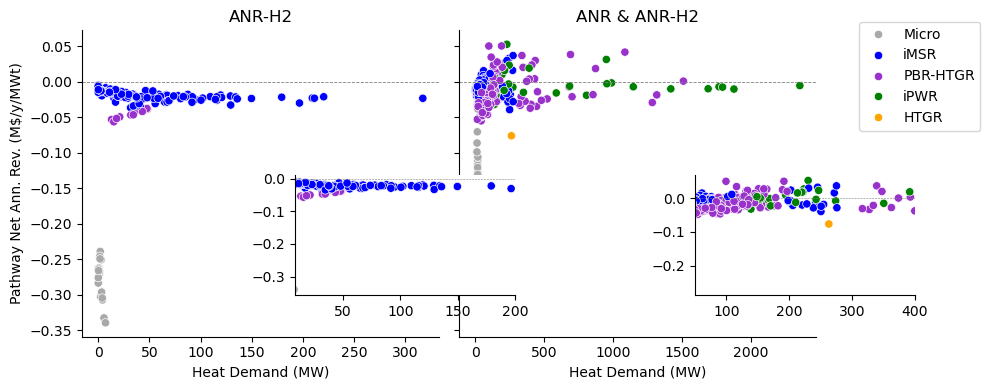

In [41]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,4))
best_pathway['Pathway Net Ann. Rev. (M$/y)'] = best_pathway['Pathway Net Ann. Rev. ($/year)']/1e6
sns.scatterplot(ax=ax[0], data=best_pathway[best_pathway.Pathway == 'ANR-H2'], x= 'Heat Demand (MW)', \
                y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=utils.palette)
sns.scatterplot(ax=ax[1], data=best_pathway[best_pathway.Pathway == 'ANR+ANR-H2'], x= 'Heat Demand (MW)', \
                y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=utils.palette)
ax[0].axhline(0, color='grey', linestyle='--', linewidth=0.6)
ax[0].set_title('ANR-H2')
ax[0].get_legend().set_visible(False)
ax[1].axhline(0, color='grey', linestyle='--', linewidth=0.6)
ax[1].set_title('ANR & ANR-H2')
ax[1].legend(bbox_to_anchor=(1.1, 1.05))
# Zoom of ANR and ANR-H2
# this is an inset axes over the main axes
sub_ax = plt.axes([.7, .25, .22, .3]) 
sns.scatterplot(ax=sub_ax, data=best_pathway[best_pathway.Pathway == 'ANR+ANR-H2'], x= 'Heat Demand (MW)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=utils.palette)
sub_ax.axhline(0, color='grey', linestyle='--', linewidth=0.4)
sub_ax.set_xlim(50,400)
#sub_ax.set_ylim(-.01, 0.2)
sub_ax.get_legend().set_visible(False)
sub_ax.set_xlabel('')
sub_ax.set_ylabel('')
# Zoom of ANR-H2
# this is an inset axes over the main axes
sub_ax = plt.axes([.3, .25, .22, .3]) 
sns.scatterplot(ax=sub_ax, data=best_pathway[best_pathway.Pathway == 'ANR-H2'], x= 'Heat Demand (MW)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=utils.palette)
sub_ax.axhline(0, color='grey', linestyle='--', linewidth=0.4)
sub_ax.set_xlim(8,200)
#sub_ax.set_ylim(-.01, 0.2)
sub_ax.get_legend().set_visible(False)
sub_ax.set_xlabel('')
sub_ax.set_ylabel('')
sns.despine()
fig.tight_layout()
fig.savefig(f'./results/process_heat/best_net_ann_rev_vs_heat_demand_{OAK}_{cogen_tag}.png')

Very small demand are the least profitable to serve, and we observe that for ANR-H2 pathway the most profitable plants require a demand between 50 and 100 MWt while for the ANR & ANR-H2 pathway a profitability maximum is observed between 200 and 300 MWt. 

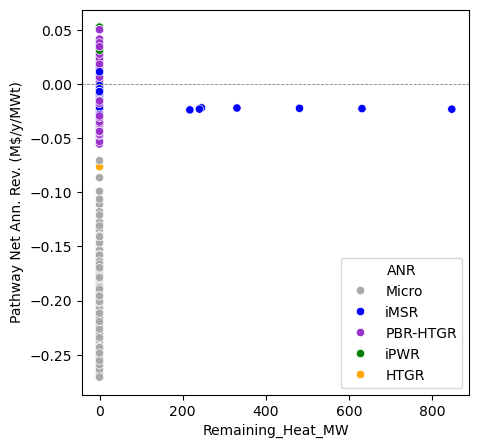

In [42]:
fig, ax = plt.subplots(sharey=True, figsize=(5,5))
sns.scatterplot(ax=ax, data=best_pathway, x= 'Remaining_Heat_MW', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', palette=utils.palette)
ax.axhline(0, color='grey', linestyle='--', linewidth=0.6)


No clear influence of remaining heat on profitability

### Influence of surplus capacity on profitability

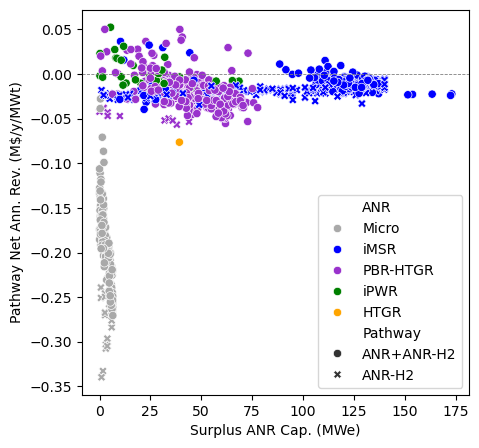

In [43]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(ax=ax, data=best_pathway, x= 'Surplus ANR Cap. (MWe)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', style='Pathway', palette=utils.palette)
ax.axhline(0, color='grey', linestyle='--', linewidth=0.6)

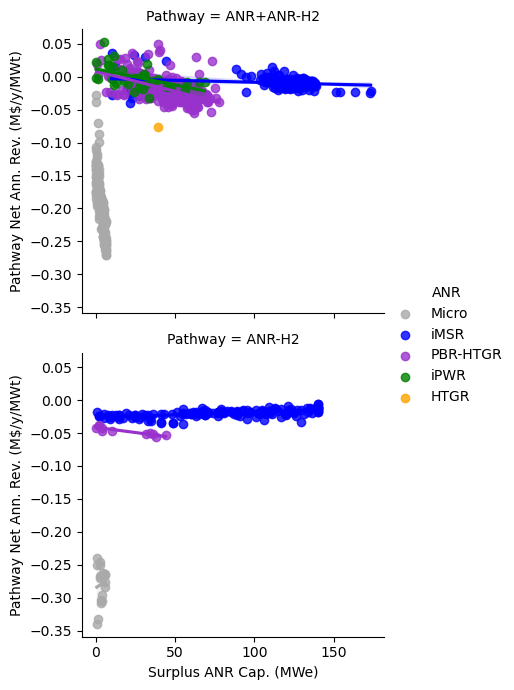

In [44]:
g = sns.lmplot( data=best_pathway, x= 'Surplus ANR Cap. (MWe)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', row='Pathway', palette=utils.palette, scatter=True, fit_reg=True, height=3.5, aspect=1.2)
g.savefig(f'./results/process_heat/best_net_ann_rev_vs_surplus_capacity_anr_{OAK}_{cogen_tag}.png')

### Net Annual Revenues per Industry

In [45]:
map_id_industry =pd.read_excel('./input_data/direct_heat_maxv/maxv_heat_data_old.xlsx')[['FACILITY_ID', 'Industry']]
map_id_industry.drop_duplicates(inplace=True, ignore_index=True)
best_pathway_mapped = best_pathway.merge(map_id_industry, on='FACILITY_ID', how='left')
best_pathway_mapped['Industry'] = best_pathway_mapped['Industry'].fillna('Other')
best_pathway_mapped.replace({'Other_Not Found':'Other'}, inplace=True)

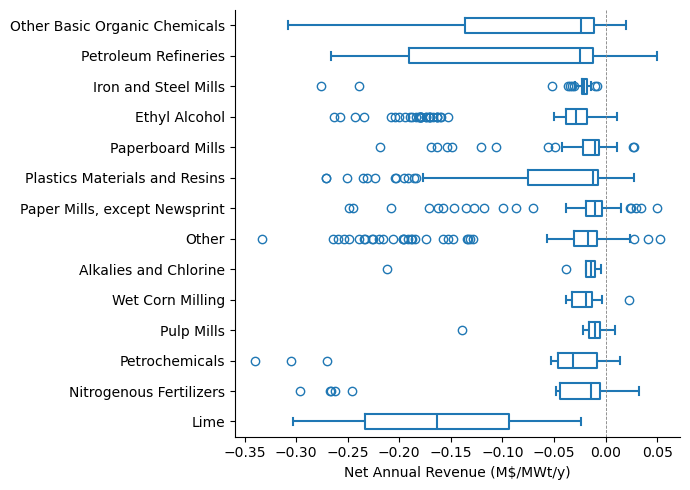

In [46]:
save_path = f'./results/process_heat/best_net_ann_rev_vs_industry_{OAK}_{cogen_tag}.png'
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(ax=ax, data=best_pathway_mapped, y='Industry', x='Pathway Net Ann. Rev. (M$/y/MWt)',fill=False, width=.5)
ax.set_ylabel('')
ax.set_xlabel('Net Annual Revenue (M$/MWt/y)')
sns.despine()
ax.axvline(0, color='grey', linestyle='--', linewidth=0.6)
#ax.legend(bbox_to_anchor=(-0.1, .01))

fig.tight_layout()
fig.savefig(save_path)

### Cost comparison against NG with CCUS

Cost of NG+CCUS = Avoided NG Cost + Emissions x CCUS Cost

Cost of ANR = CAPEX + O&M + Conversion - H2 PTC 

In [47]:
comp_ccus = best_pathway_mapped.copy()
comp_ccus['Cost NG + CCUS (M$/MWt/y)'] = (comp_ccus['Avoided NG Cost ($/y)']+comp_ccus['Emissions_mmtco2/y']*utils.ccus_cost*1e6)/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)
if cogen: comp_ccus['Cost ANR deployment (M$/MWt/y)'] = (comp_ccus['CAPEX ($/y)']+comp_ccus['O&M ($/y)']+comp_ccus['Conversion']-\
                                                comp_ccus['H2 PTC']-comp_ccus['Electricity revenues ($/y)'])/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)
else: comp_ccus['Cost ANR deployment (M$/MWt/y)'] = (comp_ccus['CAPEX ($/y)']+comp_ccus['O&M ($/y)']+comp_ccus['Conversion']-\
                                                comp_ccus['H2 PTC'])/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)
comp_ccus['Cost NG + CCUS 25 (M$/MWt/y)'] = (comp_ccus['Avoided NG Cost ($/y)']+comp_ccus['Emissions_mmtco2/y']*25*1e6)/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)
comp_ccus['Cost NG + CCUS 100 (M$/MWt/y)'] = (comp_ccus['Avoided NG Cost ($/y)']+comp_ccus['Emissions_mmtco2/y']*100*1e6)/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)

In [48]:
# Compute viable deployed capacity 
ccus_50 = comp_ccus[comp_ccus['Cost NG + CCUS (M$/MWt/y)']>=comp_ccus['Cost ANR deployment (M$/MWt/y)']]
ccus_25 = comp_ccus[comp_ccus['Cost NG + CCUS 25 (M$/MWt/y)']>=comp_ccus['Cost ANR deployment (M$/MWt/y)']]
ccus_100 = comp_ccus[comp_ccus['Cost NG + CCUS 100 (M$/MWt/y)']>=comp_ccus['Cost ANR deployment (M$/MWt/y)']]
print('At {} $/ton, viable deployed ANR capacity {} GWt'.format(50, ccus_50['Depl. ANR Cap. (MWt)'].sum()/1e3))
print('At {} $/ton, viable deployed ANR capacity {} GWt'.format(25, ccus_25['Depl. ANR Cap. (MWt)'].sum()/1e3))
print('At {} $/ton, viable deployed ANR capacity {} GWt'.format(100, ccus_100['Depl. ANR Cap. (MWt)'].sum()/1e3))

At 50 $/ton, viable deployed ANR capacity 104.39 GWt
At 25 $/ton, viable deployed ANR capacity 75.72 GWt
At 100 $/ton, viable deployed ANR capacity 154.18 GWt


In [49]:
comp_ccus = comp_ccus.rename(columns={'Emissions_mmtco2/y': 'Emissions (MMtCO2/y)'})

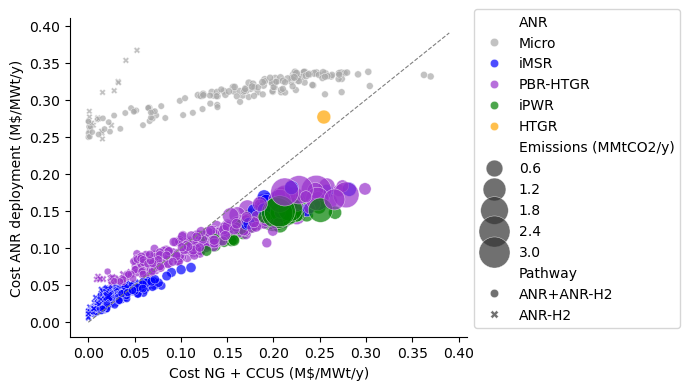

In [50]:
save_path = f'./results/process_heat/best_comparison_costs_vs_ccus_anr_{OAK}_{cogen_tag}.png'

fig, ax = plt.subplots(figsize=(7,4))
med_x = np.arange(0,0.4, 0.01)
sns.scatterplot(ax=ax, data=comp_ccus, y='Cost ANR deployment (M$/MWt/y)', x='Cost NG + CCUS (M$/MWt/y)', hue='ANR',\
                 size='Emissions (MMtCO2/y)', sizes=(20,500), size_norm=(0,2.3), style='Pathway',palette=utils.palette, alpha=.7)
ax.plot(med_x, med_x, color='grey', linestyle='--', linewidth=0.8)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1.05))

fig.tight_layout()
fig.savefig(save_path)

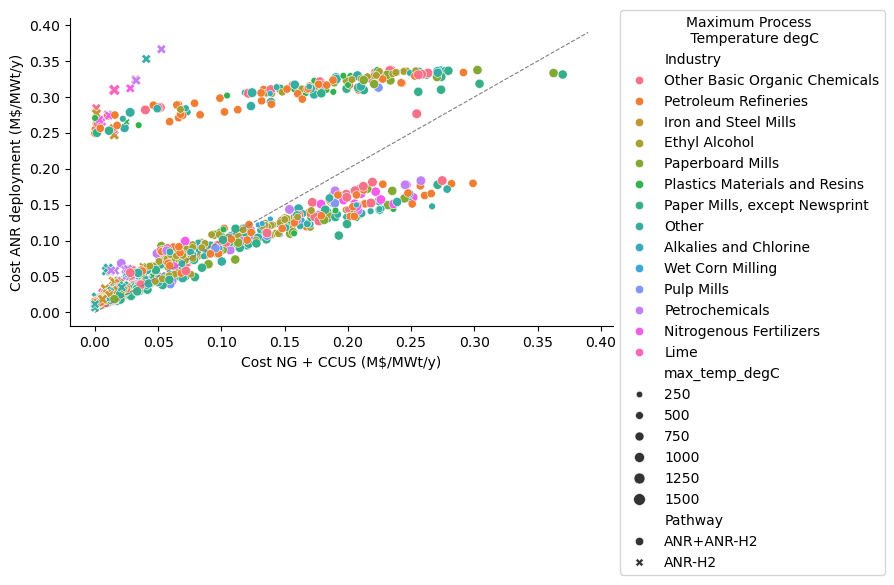

In [51]:
save_path = f'./results/process_heat/best_comparison_costs_vs_ccus_industry_{OAK}_{cogen_tag}.png'

fig, ax = plt.subplots(figsize=(7,4))
med_x = np.arange(0,0.4, 0.01)
sns.scatterplot(ax=ax, data=comp_ccus, y='Cost ANR deployment (M$/MWt/y)', x='Cost NG + CCUS (M$/MWt/y)', hue='Industry', size='max_temp_degC', style='Pathway')
ax.plot(med_x, med_x, color='grey', linestyle='--', linewidth=0.8)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1.05), title='Maximum Process\n Temperature degC')

fig.savefig(save_path)

### Emissions abatement costs

In [52]:
best_pathway.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. FOAK ($/year)', 'H2 Dem. (kg/h)', 'Technology',
       'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF', 'Annual ANR-H2 CAPEX',
       'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM', 'ANR FOM', 'ANR-H2 VOM',
       'Conversion', 'ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)',
       'H2 PTC', 'Electricity revenues ($/y)', 'Depl. ANR Cap. (MWe)',
       'Depl. ANR Cap. (MWt)', 'Surplus ANR Cap. (MWe)',
       'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'CAPEX ($/y)', 'O&M ($/y)',
       'ANR-H2 Net Ann.

In [53]:
em = best_pathway.copy()
em['Cost ANR ($/y)'] = (em['CAPEX ($/y)']+em['O&M ($/y)']+em['Conversion']-em['Avoided NG Cost ($/y)'])
em['Abatement cost ($/tCO2)'] = em['Cost ANR ($/y)']/(em['Emissions_mmtco2/y']*1e6)
em['Abatement potential (tCO2/y-MWe)'] = 1e6*em['Emissions_mmtco2/y']/em['Depl. ANR Cap. (MWe)']
min_cost = min(em['Abatement cost ($/tCO2)'])
max_cost = max(em['Abatement cost ($/tCO2)'])
min_cost_anr = min(em['Cost ANR ($/y)'])
max_cost_anr = max(em['Cost ANR ($/y)'])
print(min_cost, max_cost)
print(min_cost_anr, max_cost_anr)
print(min(em['Emissions_mmtco2/y']), max(em['Emissions_mmtco2/y']))

-35.12759816635167 1667348.219413199
-38740924.922383964 1311258813.3469296
4.053e-06 3.399976439


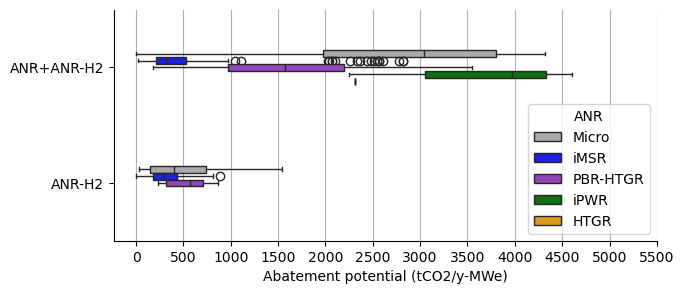

In [54]:
fig, ax = plt.subplots(figsize=(7,3))

sns.boxplot(ax=ax, data=em, y='Pathway', x='Abatement potential (tCO2/y-MWe)', palette=utils.palette, hue='ANR',width=0.3)
ax.set_ylabel('')
ax.xaxis.set_ticks(np.arange(0, 6000, 500))
sns.despine()
ax.xaxis.grid(True)
fig.savefig(f'./results/process_heat/best_abatement_potential_vs_pathway_anr_{OAK}_{cogen_tag}.png')

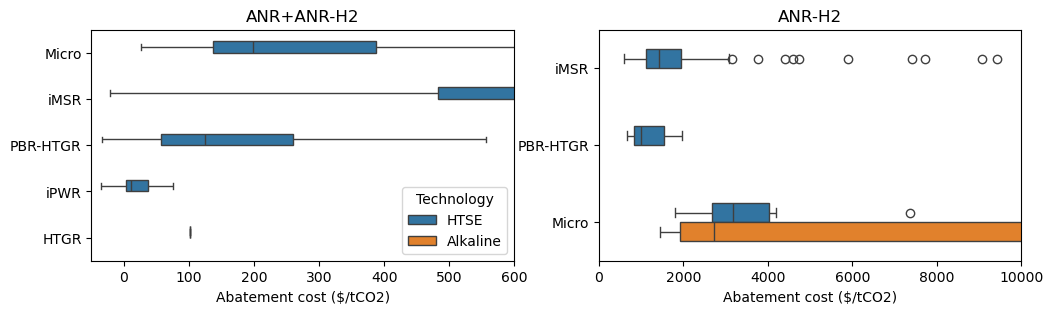

In [55]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
sns.boxplot(ax=ax[0], data=em[em.Pathway=='ANR+ANR-H2'], y='ANR', x='Abatement cost ($/tCO2)', hue='Technology',width=0.5)
sns.boxplot(ax=ax[1], data=em[em.Pathway=='ANR-H2'], y='ANR', x='Abatement cost ($/tCO2)', hue='Technology',width=0.5)
ax[1].set_xlim(0,10000)
ax[1].set_title('ANR-H2')
ax[0].set_xlim(-50,600)
ax[0].set_title('ANR+ANR-H2')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[1].get_legend().set_visible(False)
fig.savefig(f'./results/process_heat/best_abatement_cost_vs_anr_h2tech_{OAK}_{cogen_tag}.png')

In [56]:
anr_anrh2 = best_pathway[best_pathway.Pathway == 'ANR+ANR-H2']
anr_anrh2['ANR-only Cost ($/y)'] = anr_anrh2['Annual ANR CAPEX']+anr_anrh2[f'VOPEX_{OAK}']+anr_anrh2[f'FOPEX_{OAK}']
anr_anrh2['ANR-H2-only Cost ($/y)'] = anr_anrh2['Annual ANR-H2 CAPEX']+anr_anrh2['ANR-H2 FOM']+anr_anrh2['ANR-H2 VOM']
anr_anrh2.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. FOAK ($/year)', 'H2 Dem. (kg/h)', 'Technology',
       'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF', 'Annual ANR-H2 CAPEX',
       'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM', 'ANR FOM', 'ANR-H2 VOM',
       'Conversion', 'ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)',
       'H2 PTC', 'Electricity revenues ($/y)', 'Depl. ANR Cap. (MWe)',
       'Depl. ANR Cap. (MWt)', 'Surplus ANR Cap. (MWe)',
       'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'CAPEX ($/y)', 'O&M ($/y)',
       'ANR-H2 Net Ann.

In [57]:
anr_anrh2['Abatement cost ANR ($/tCO2)'] = (anr_anrh2['ANR-only Cost ($/y)']-anr_anrh2['Avoided NG Cost ($/y)'])/(anr_anrh2['Emissions_batch_mmtco2/y']*1e6)
anr_anrh2['Abatement cost ANR-H2 ($/tCO2)'] = (anr_anrh2['ANR-H2-only Cost ($/y)']-anr_anrh2['Avoided NG Cost ($/y)'])/(anr_anrh2['Emissions_rem_mmtco2/y']*1e6)

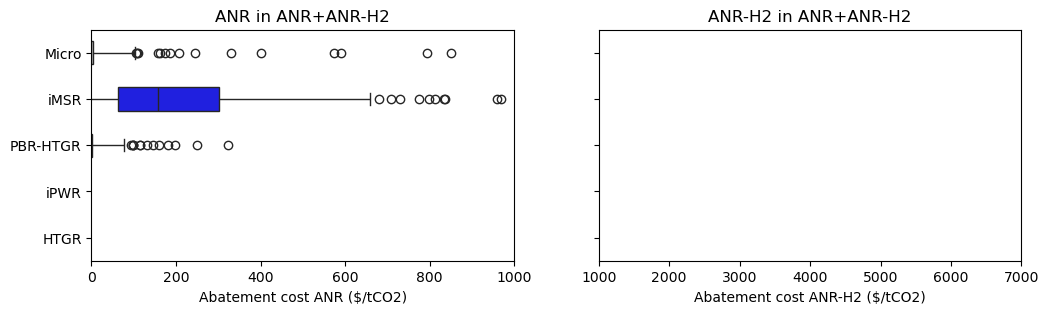

In [58]:
fig, ax = plt.subplots(1,2,figsize=(12,3), sharey=True)

sns.boxplot(ax=ax[0], data=anr_anrh2, y='ANR', x='Abatement cost ANR ($/tCO2)', hue='ANR',width=0.5, palette=utils.palette)
sns.boxplot(ax=ax[1], data=anr_anrh2, y='ANR', x='Abatement cost ANR-H2 ($/tCO2)', hue='ANR',width=0.5, palette=utils.palette)
ax[1].set_xlim(1000,7000)
ax[1].set_title('ANR-H2 in ANR+ANR-H2')
ax[0].set_xlim(0,1000)
ax[0].set_title('ANR in ANR+ANR-H2')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
#ax[1].get_legend().set_visible(False)
fig.savefig(f'./results/process_heat/best_anr+anrh2_abatement_cost_2_steps_{OAK}_{cogen_tag}.png')

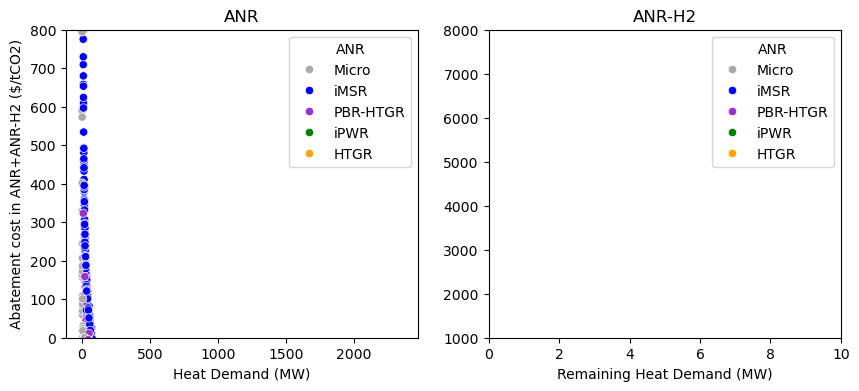

In [59]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(ax=ax[0], data=anr_anrh2, y='Abatement cost ANR ($/tCO2)', x='Heat Demand (MW)', hue='ANR', palette=utils.palette)
ax[0].set_ylim(0,800)
ax[0].set_ylabel('Abatement cost in ANR+ANR-H2 ($/tCO2)')
ax[0].set_title('ANR')
sns.scatterplot(ax=ax[1], data=anr_anrh2, y='Abatement cost ANR-H2 ($/tCO2)', x='Remaining_Heat_MW', hue='ANR', palette=utils.palette)
ax[1].set_ylim(1000,8000)
ax[1].set_xlim(0,10)
ax[1].set_ylabel('')
ax[1].set_title('ANR-H2')
ax[1].set_xlabel('Remaining Heat Demand (MW)')
#ax[1].get_legend().set_visible(False)
fig.savefig(f'./results/process_heat/best_anr+anrh2_abatement_cost_vs_heat_demand_anr_design_{OAK}_{cogen_tag}.png')

### Influence of temperature on profitability

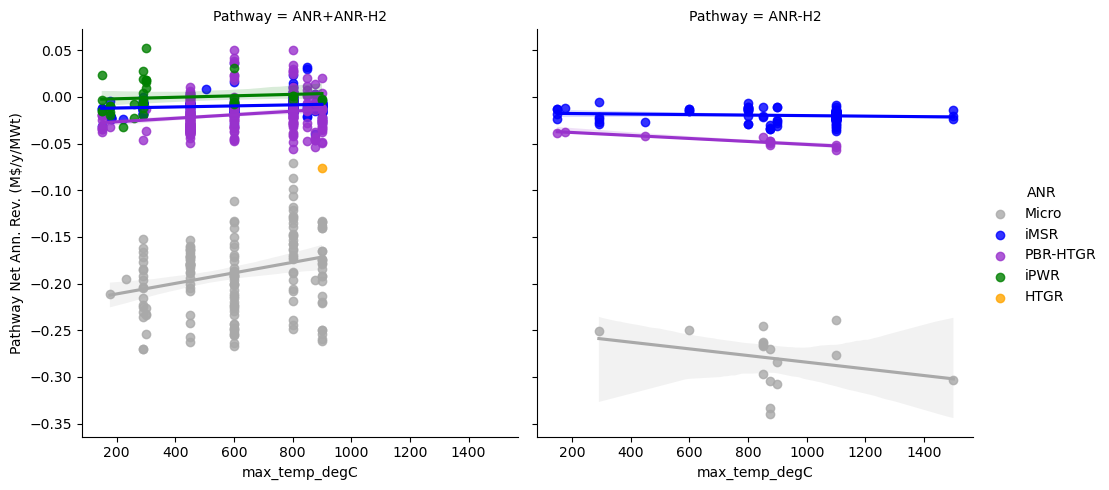

In [60]:

sns.lmplot( data=best_pathway, x= 'max_temp_degC', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='ANR', col='Pathway', palette=utils.palette)


No influence of max temperature at facility on profitability

### Influence of electrolysis technology on profitability

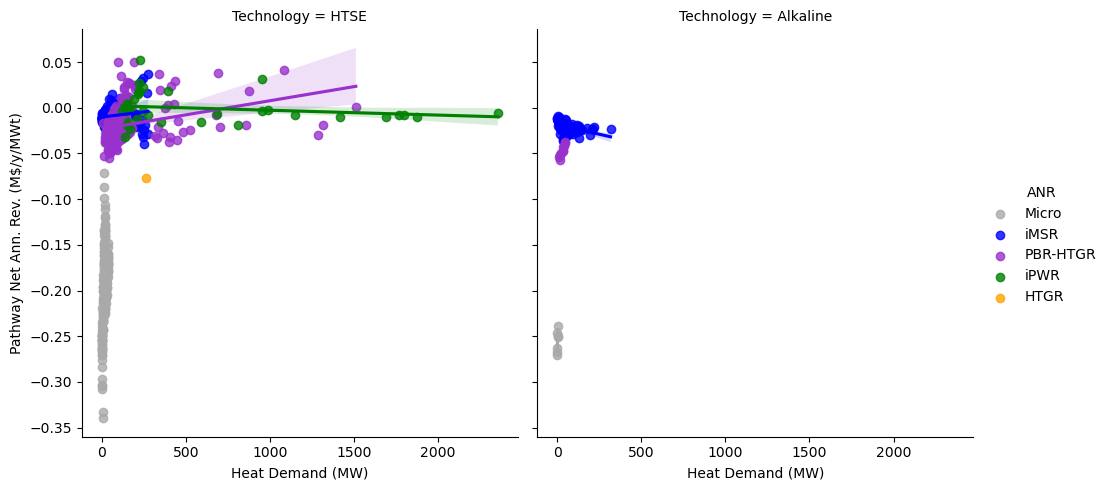

In [61]:


sns.lmplot(data=best_pathway, y= 'Pathway Net Ann. Rev. (M$/y/MWt)', x = 'Heat Demand (MW)', hue='ANR', col='Technology', palette=utils.palette)


### Comparison against NG without CCUS

In [62]:
comp_ccus['Cost NG without CCUS (M$/MWt/y)'] = comp_ccus['Avoided NG Cost ($/y)']/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)
comp_ccus.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions (MMtCO2/y)',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. FOAK ($/year)', 'H2 Dem. (kg/h)', 'Technology',
       'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF', 'Annual ANR-H2 CAPEX',
       'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM', 'ANR FOM', 'ANR-H2 VOM',
       'Conversion', 'ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)',
       'H2 PTC', 'Electricity revenues ($/y)', 'Depl. ANR Cap. (MWe)',
       'Depl. ANR Cap. (MWt)', 'Surplus ANR Cap. (MWe)',
       'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'CAPEX ($/y)', 'O&M ($/y)',
       'ANR-H2 Net An

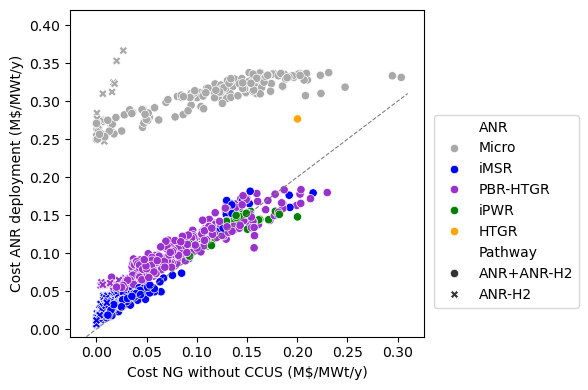

In [63]:
fig, ax = plt.subplots(sharey=True, figsize=(6,4))

sns.scatterplot(ax=ax, data=comp_ccus, x= 'Cost NG without CCUS (M$/MWt/y)', y = 'Cost ANR deployment (M$/MWt/y)', hue='ANR', style='Pathway', palette=utils.palette)
med_x = np.arange(-0.01,0.32, 0.01)
ax.plot(med_x, med_x, color='grey', linestyle='--', linewidth=0.8)
ax.legend(bbox_to_anchor=(1.01, .7))
ax.set_ylim(-0.01, 0.42)
fig.tight_layout()
fig.savefig(f'./results/process_heat/best_comparison_costs_vs_ng_wo_ccus_{OAK}_{cogen_tag}.png')


### Breakeven NG prices

In [64]:
bmp = best_pathway_mapped.copy()
bmp.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. FOAK ($/year)', 'H2 Dem. (kg/h)', 'Technology',
       'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF', 'Annual ANR-H2 CAPEX',
       'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM', 'ANR FOM', 'ANR-H2 VOM',
       'Conversion', 'ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)',
       'H2 PTC', 'Electricity revenues ($/y)', 'Depl. ANR Cap. (MWe)',
       'Depl. ANR Cap. (MWt)', 'Surplus ANR Cap. (MWe)',
       'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'CAPEX ($/y)', 'O&M ($/y)',
       'ANR-H2 Net Ann.

In [65]:
bmp[['H2 PTC','Avoided NG Cost ($/y)','Annual H2 CAPEX','O&M ($/y)','Conversion','Depl. ANR Cap. (MWe)','ANR CRF','ANR CAPEX ($/MWe)']]

,H2 PTC,Avoided NG Cost ($/y),Annual H2 CAPEX,O&M ($/y),Conversion,Depl. ANR Cap. (MWe),ANR CRF,ANR CAPEX ($/MWe)
0,0.000000e+00,3.269682e+06,0.000000e+00,1.742400e+06,0.000000e+00,6.6,0.099589,10902000
1,0.000000e+00,5.897046e+06,0.000000e+00,1.363022e+07,0.000000e+00,141.0,0.077909,4091000
2,3.472257e+07,2.432455e+06,3.733672e+06,2.349401e+07,3.291176e+06,141.0,0.077909,4091000
3,0.000000e+00,2.461294e+07,0.000000e+00,1.349151e+07,0.000000e+00,80.0,0.077909,4569000
4,0.000000e+00,5.822880e+06,0.000000e+00,1.328882e+07,0.000000e+00,141.0,0.077909,4091000
...,...,...,...,...,...,...,...,...
914,0.000000e+00,4.056301e+06,0.000000e+00,1.742400e+06,0.000000e+00,6.6,0.099589,10902000
915,1.983179e+05,2.408441e+04,4.020976e+04,1.221078e+07,2.627706e+04,141.0,0.077909,4091000
916,0.000000e+00,3.078023e+06,0.000000e+00,1.742400e+06,0.000000e+00,6.6,0.099589,10902000
917,0.000000e+00,2.913175e+06,0.000000e+00,1.742400e+06,0.000000e+00,6.6,0.099589,10902000


In [66]:
# Recalculate NG multiplier from max temperature recorded

bmp['NG Mult (MMBtu/MJ)']  = bmp.apply(lambda x: compute_ng_multiplier(x['max_temp_degC']), axis=1) 
if cogen: bmp['Breakeven NG price ($/MMBtu)'] = (bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion']-bmp['H2 PTC']-bmp['Electricity revenues ($/y)'])/\
                                              (bmp['NG Mult (MMBtu/MJ)']*bmp['Heat Demand (MW)']*utils.mwh_to_mj*8760)
else: bmp['Breakeven NG price ($/MMBtu)'] = (bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion']-bmp['H2 PTC'])/\
                                              (bmp['NG Mult (MMBtu/MJ)']*bmp['Heat Demand (MW)']*utils.mwh_to_mj*8760)
if cogen: bmp['BE wo PTC ($/MMBtu)'] = (bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion']-bmp['Electricity revenues ($/y)'])/\
                                              (bmp['NG Mult (MMBtu/MJ)']*bmp['Heat Demand (MW)']*utils.mwh_to_mj*8760)
else: bmp['BE wo PTC ($/MMBtu)'] = (bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion'])/\
                                              (bmp['NG Mult (MMBtu/MJ)']*bmp['Heat Demand (MW)']*utils.mwh_to_mj*8760)
if cogen:
  bmp['Breakeven CAPEX ($/MWe)'] = (bmp['H2 PTC']+bmp['Electricity revenues ($/y)']+bmp['Avoided NG Cost ($/y)']\
  -(bmp['Annual H2 CAPEX']+bmp['O&M ($/y)']+bmp['Conversion']))/(bmp['Depl. ANR Cap. (MWe)']*bmp['ANR CRF']*(1-utils.ITC_ANR))
  # Cost reduction compared to capex 
  bmp['Cost red CAPEX BE'] = bmp.apply(lambda x:max(0,1-(x['Breakeven CAPEX ($/MWe)']/x['ANR CAPEX ($/MWe)'])), axis=1)
else: 
  bmp['Breakeven CAPEX ($/MWe)'] = (bmp['H2 PTC']+bmp['Avoided NG Cost ($/y)']\
  -(bmp['Annual H2 CAPEX']+bmp['O&M ($/y)']+bmp['Conversion']))/(bmp['Depl. ANR Cap. (MWe)']*bmp['ANR CRF']*(1-utils.ITC_ANR))
  # Cost reduction compared to capex 
  bmp['Cost red CAPEX BE'] = bmp.apply(lambda x:max(0,1-(x['Breakeven CAPEX ($/MWe)']/x['ANR CAPEX ($/MWe)'])), axis=1)

max_ng = max(bmp['Breakeven NG price ($/MMBtu)'])
min_ng = min(bmp['Breakeven NG price ($/MMBtu)'])
print(f'Breakeven NG prices between {min_ng} and {max_ng} $/MMBtu')
bmp

Breakeven NG prices between 6.19323660531817 and 87646.58380311089 $/MMBtu


,FACILITY_ID,STATE,CITY,latitude,longitude,Batch_Temp_degC,max_temp_degC,Emissions_mmtco2/y,Emissions_batch_mmtco2/y,Emissions_rem_mmtco2/y,...,ANR-H2 Net Ann. Rev. ($/year),Pathway Net Ann. Rev. (M$/y),Pathway Net Ann. Rev. (M$/y/MWt),Pathway Net Ann. Rev. (M$/y/MWe),Industry,NG Mult (MMBtu/MJ),Breakeven NG price ($/MMBtu),BE wo PTC ($/MMBtu),Breakeven CAPEX ($/MWe),Cost red CAPEX BE
0,1000022,TX,TEXAS CITY,29.396013,-94.917548,421.391304,900,0.028326,0.028326,0.0,...,NaN,-3.476944,-0.173847,-0.526810,Other Basic Organic Chemicals,0.000534,20.407008,20.407008,3.345090e+06,0.693167
1,1000025,LA,PORT ALLEN,30.453350,-91.210057,457.187911,600,0.050151,0.050151,0.0,...,NaN,-4.913940,-0.016380,-0.034851,Petroleum Refineries,0.000642,15.362569,15.362569,3.451966e+06,0.156205
2,1000029,WA,SEATTLE,47.603832,-122.330062,NaN,1100,0.038366,NaN,NaN,...,-6.755531e+06,-6.755531,-0.022518,-0.047912,Iron and Steel Mills,0.000462,23.474154,112.185961,3.212476e+06,0.214746
3,1000035,OH,GREENVILLE,40.102391,-84.633299,382.244726,450,0.173995,0.173995,0.0,...,NaN,0.052197,0.000261,0.000652,Ethyl Alcohol,0.000696,9.278992,9.278992,4.580964e+06,0.000000
4,1000041,WI,MILWAUKEE,43.038648,-87.909075,451.510481,800,0.039744,0.039744,0.0,...,NaN,-4.710558,-0.015702,-0.033408,Paperboard Mills,0.000570,21.273697,21.273697,3.478415e+06,0.149740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,1011979,IN,Valparaiso,41.467255,-87.060449,477.685001,800,0.027314,0.027314,0.0,...,NaN,-2.620179,-0.131009,-0.396997,Other,0.000570,19.620592,19.620592,5.207212e+06,0.522362
915,1012002,OH,Cincinnati,39.101454,-84.512460,NaN,800,0.000306,NaN,NaN,...,-3.418955e+06,-3.418955,-0.011397,-0.024248,Other,0.000570,892.966478,944.401032,3.646381e+06,0.108682
916,1012019,IA,Tama,42.056811,-92.543392,451.510481,800,0.023461,0.023461,0.0,...,NaN,-3.393330,-0.169666,-0.514141,Paperboard Mills,0.000570,22.140357,22.140357,3.526819e+06,0.676498
917,1012036,NE,Mead,41.226621,-96.489259,382.244726,450,0.022998,0.022998,0.0,...,NaN,-3.570835,-0.178542,-0.541036,Ethyl Alcohol,0.000696,18.533208,18.533208,3.141025e+06,0.711885


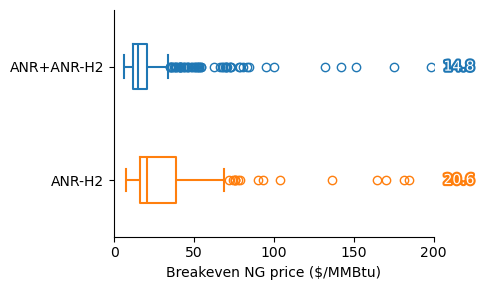

In [67]:
save_path = f'./results/process_heat/best_breakeven_ng_vs_pathway_{OAK}_{cogen_tag}.png'
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(ax=ax, data=bmp, y='Pathway', x='Breakeven NG price ($/MMBtu)', hue='Pathway',fill=False, width=.4)
ax.set_xlim(0,200)
ax.set_ylabel('')
sns.despine()

import matplotlib.patheffects as path_effects


def add_median_labels_outside(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        xleftlim,xrightlim = ax.get_xlim()
        text = ax.text(xrightlim*1.08, y, f'{value:{fmt}}', ha='center', va='center', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])
add_median_labels_outside(ax)
fig.tight_layout()
fig.savefig(save_path)

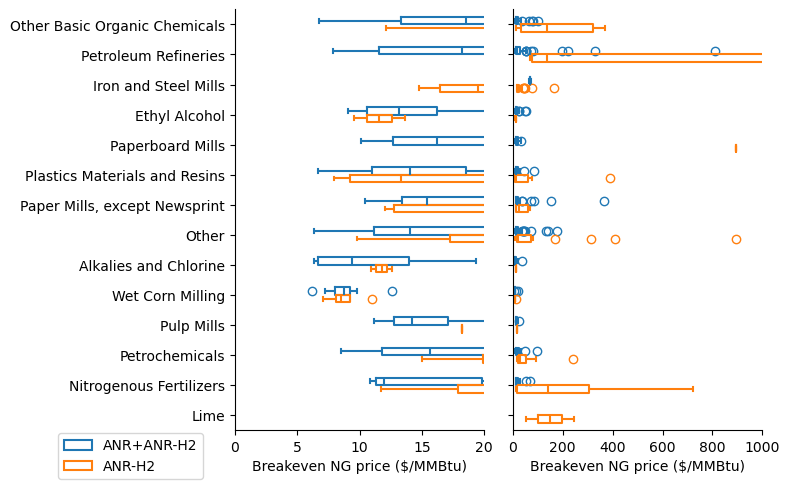

In [68]:
save_path = f'./results/process_heat/best_breakeven_ng_vs_industry_{OAK}_{cogen_tag}.png'
fig, ax = plt.subplots(1,2,figsize=(8,5), sharey=True)
sns.boxplot(ax=ax[0], data=bmp, y='Industry', x='Breakeven NG price ($/MMBtu)', hue='Pathway',fill=False, width=.5)
sns.boxplot(ax=ax[1], data=bmp, y='Industry', x='Breakeven NG price ($/MMBtu)', hue='Pathway',fill=False, width=.5)
ax[0].set_ylabel('')

ax[0].set_xlim(0,20)
ax[1].set_ylabel('')
ax[1].set_xlim(0,1000)
ax[1].get_legend().set_visible(False)
sns.despine()

ax[0].legend(bbox_to_anchor=(-0.1, .01))

fig.tight_layout()
fig.savefig(save_path)

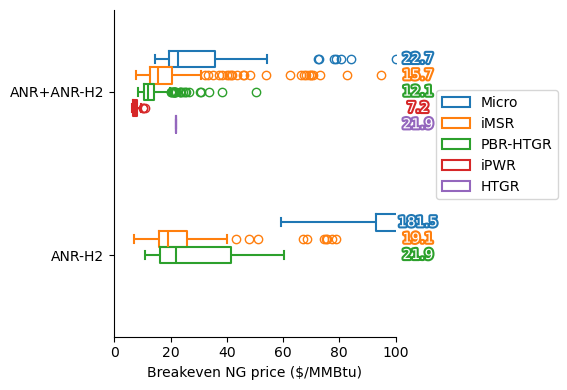

In [69]:
save_path = f'./results/process_heat/best_breakeven_ng_vs_pathway_anr_{OAK}_{cogen_tag}.png'
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(ax=ax, data=bmp, y='Pathway', x='Breakeven NG price ($/MMBtu)', hue='ANR',fill=False, width=.5)
ax.set_ylabel('')
ax.set_xlim(0,100)
sns.despine()
ax.legend(bbox_to_anchor=(1.12, .4))

add_median_labels_outside(ax)
fig.tight_layout()
fig.savefig(save_path)

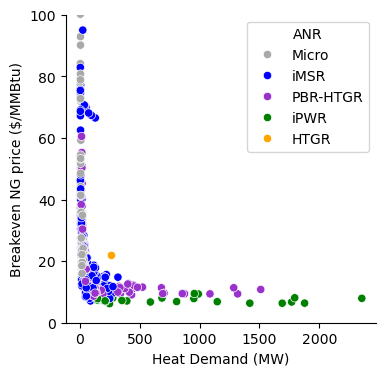

In [70]:
# Scatter plots: Heat demand
fig, ax = plt.subplots(sharey=True, figsize=(4,4))

sns.scatterplot(ax=ax, data=bmp, x= 'Heat Demand (MW)', y = 'Breakeven NG price ($/MMBtu)', hue='ANR', palette=utils.palette)

ax.set_ylim(0,100)
sns.despine()
fig.savefig(f'./results/process_heat/best_be_ng_vs_heat_demand_{OAK}_{cogen_tag}.png')

### Calculation abatement cost and potential

In [71]:
bmp.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. FOAK ($/year)', 'H2 Dem. (kg/h)', 'Technology',
       'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF', 'Annual ANR-H2 CAPEX',
       'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM', 'ANR FOM', 'ANR-H2 VOM',
       'Conversion', 'ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)',
       'H2 PTC', 'Electricity revenues ($/y)', 'Depl. ANR Cap. (MWe)',
       'Depl. ANR Cap. (MWt)', 'Surplus ANR Cap. (MWe)',
       'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'CAPEX ($/y)', 'O&M ($/y)',
       'ANR-H2 Net Ann.

In [72]:
bmp['Cost ANR ($/y)'] = bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion']-bmp['Avoided NG Cost ($/y)']
bmp['Abatement cost ($/tCO2)'] = bmp['Cost ANR ($/y)']/(bmp['Emissions_mmtco2/y']*1e6)
bmp['Abatement potential (tCO2/y-MWe)'] = 1e6*bmp['Emissions_mmtco2/y']/bmp['Depl. ANR Cap. (MWe)']

In [73]:
bmp.to_excel(f'./results/process_heat/best_pathway_{OAK}_{cogen_tag}.xlsx')

### Cashflows breakdown

In [74]:
color_map = {'ANR CAPEX': 'navy', 
             'ANR for H2 CAPEX': 'royalblue',
               'H2 CAPEX': 'lightsteelblue', 
               'ANR O&M':'darkgreen', 
               'ANR for H2 O&M':'forestgreen', 
               'H2 O&M':'palegreen',
               'Avoided Fossil Fuel Costs':'darkorchid', 
               'H2 PTC':'plum', 
               'Electricity':'pink'}
best_pathway.columns



Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. FOAK ($/year)', 'H2 Dem. (kg/h)', 'Technology',
       'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF', 'Annual ANR-H2 CAPEX',
       'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM', 'ANR FOM', 'ANR-H2 VOM',
       'Conversion', 'ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)',
       'H2 PTC', 'Electricity revenues ($/y)', 'Depl. ANR Cap. (MWe)',
       'Depl. ANR Cap. (MWt)', 'Surplus ANR Cap. (MWe)',
       'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'CAPEX ($/y)', 'O&M ($/y)',
       'ANR-H2 Net Ann.

In [75]:
best_pathway['Annual ANR CAPEX']

0       0.000000e+00
1       0.000000e+00
915     3.145830e+07
3       0.000000e+00
4       0.000000e+00
            ...     
908     0.000000e+00
1828    3.145830e+07
910     0.000000e+00
911     0.000000e+00
912     0.000000e+00
Name: Annual ANR CAPEX, Length: 919, dtype: float64

In [76]:
cashflows_df_anr_anrh2 = best_pathway[best_pathway.Pathway=='ANR+ANR-H2']

cashflows_df_anr_anrh2['ANR CAPEX'] = -cashflows_df_anr_anrh2[f'Annual_CAPEX_{OAK}']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['ANR for H2 CAPEX'] = -cashflows_df_anr_anrh2['Annual ANR CAPEX']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['H2 CAPEX'] = -cashflows_df_anr_anrh2['Annual H2 CAPEX']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['ANR O&M'] = -(cashflows_df_anr_anrh2[f'FOPEX_{OAK}']+cashflows_df_anr_anrh2[f'VOPEX_{OAK}'])/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['ANR for H2 O&M'] = -(cashflows_df_anr_anrh2['ANR VOM']+cashflows_df_anr_anrh2['ANR FOM'])/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['H2 O&M'] = -(cashflows_df_anr_anrh2['H2 VOM']+cashflows_df_anr_anrh2['H2 FOM'])/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['Avoided Fossil Fuel Costs'] = cashflows_df_anr_anrh2['Avoided NG Cost ($/y)']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['H2 PTC'] = cashflows_df_anr_anrh2['H2 PTC']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
if cogen: cashflows_df_anr_anrh2['Electricity'] = cashflows_df_anr_anrh2['Electricity revenues ($/y)']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])


cashflows_df_anrh2 = best_pathway[best_pathway.Pathway=='ANR-H2']

cashflows_df_anrh2['ANR CAPEX'] = 0
cashflows_df_anrh2['ANR for H2 CAPEX'] = -cashflows_df_anrh2['Annual ANR CAPEX']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['H2 CAPEX'] = -cashflows_df_anrh2['Annual H2 CAPEX']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['ANR O&M'] = 0
cashflows_df_anrh2['ANR for H2 O&M'] = -(cashflows_df_anrh2['ANR VOM']+cashflows_df_anrh2['ANR FOM'])/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['H2 O&M'] = -(cashflows_df_anrh2['H2 VOM']+cashflows_df_anrh2['H2 FOM'])/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['Avoided Fossil Fuel Costs'] = cashflows_df_anrh2['Avoided NG Cost ($/y)']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['H2 PTC'] = cashflows_df_anrh2['H2 PTC']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
if cogen: cashflows_df_anrh2['Electricity'] = cashflows_df_anrh2['Electricity revenues ($/y)']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])

In [77]:
if cogen:
  cashflows_df_anr_anrh2 = cashflows_df_anr_anrh2[['ANR', 'ANR CAPEX','ANR for H2 CAPEX','H2 CAPEX','ANR O&M','ANR for H2 O&M', 
                                                 'H2 O&M','Avoided Fossil Fuel Costs','H2 PTC', 'Electricity']]
  cashflows_df_anrh2 = cashflows_df_anrh2[['ANR', 'ANR CAPEX','ANR for H2 CAPEX','H2 CAPEX','ANR O&M','ANR for H2 O&M', 
                                                 'H2 O&M','Avoided Fossil Fuel Costs','H2 PTC', 'Electricity']]
else:
  cashflows_df_anr_anrh2 = cashflows_df_anr_anrh2[['ANR', 'ANR CAPEX','ANR for H2 CAPEX','H2 CAPEX','ANR O&M','ANR for H2 O&M', 
                                                 'H2 O&M','Avoided Fossil Fuel Costs','H2 PTC']]
  cashflows_df_anrh2 = cashflows_df_anrh2[['ANR', 'ANR CAPEX','ANR for H2 CAPEX','H2 CAPEX','ANR O&M','ANR for H2 O&M', 
                                                  'H2 O&M','Avoided Fossil Fuel Costs','H2 PTC']]

In [78]:
cashflows_df_anr_anrh2 = cashflows_df_anr_anrh2.groupby(['ANR']).mean()
cashflows_df_anrh2 = cashflows_df_anrh2.groupby(['ANR']).mean()

In [79]:
cashflows_df_anr_anrh2.to_excel(f'./results/process_heat/anr+anrh2_avg_cashflows_{OAK}_{cogen_tag}.xlsx')

In [80]:
cashflows_df_anrh2.to_excel(f'./results/process_heat/anrh2_avg_cashflows_{OAK}_{cogen_tag}.xlsx')

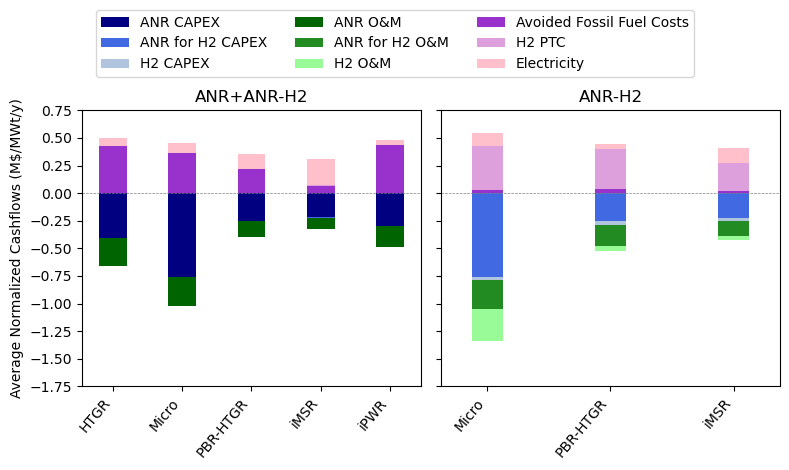

In [81]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
cashflows_df_anr_anrh2.plot(ax = ax[0], kind ='bar', stacked=True, color=color_map, width=0.4)
ax[0].set_ylabel('Average Normalized Cashflows (M$/MWt/y)')
ax[0].set_xlabel('')
ax[0].axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax[0].set_xticks(ax[0].get_xticks(), ax[0].get_xticklabels(), rotation=50, ha='right')
ax[0].set_ylim(-1.02, 0.52)
ax[0].yaxis.set_ticks(np.arange(-1.75, 1, 0.25))
ax[0].get_legend().set_visible(False)
ax[0].set_title('ANR+ANR-H2')

cashflows_df_anrh2.plot(ax = ax[1], kind ='bar', stacked=True, color=color_map, width=0.25)
ax[1].set_xlabel('')
ax[1].axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax[1].set_xticks(ax[1].get_xticks(), ax[1].get_xticklabels(), rotation=50, ha='right')
ax[1].set_ylim(-1.02, 0.52)
ax[1].yaxis.set_ticks(np.arange(-1.75, 1, 0.25))
ax[1].get_legend().set_visible(False)
ax[1].set_title('ANR-H2')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels,  bbox_to_anchor=(.5,1.18),loc='upper center', ncol=3)
fig.tight_layout()
fig.savefig(f'./results/process_heat/best_avg_cashflows_vs_pathways_anr_{OAK}_{cogen_tag}.png')
  